In [86]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
from sqlalchemy import create_engine
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from statsmodels.tools.eval_measures import mse, rmse
from wordcloud import WordCloud
import statsmodels.api as sm

import warnings

%matplotlib inline
sns.set()

warnings.filterwarnings('ignore')

In [54]:
#obtain data from the server
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

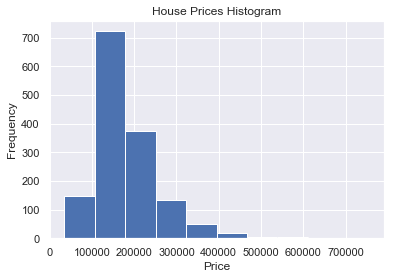

In [55]:
#view the target variable as a histogram

plt.hist(house_prices_df.saleprice)
plt.title("House Prices Histogram")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

The histogram of House Prices is not normally distributed, but instead is skewed right.

In [24]:
#examine the data frame

print(
    house_prices_df.head(),
    house_prices_df.info(),
    house_prices_df.describe()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [22]:
#determine which variables have missing values and in what percentage

missing_values_ratios = (house_prices_df.isnull().sum()/house_prices_df.isnull().count())
missing_values_ratios.sort_values(ascending=False).head(30)

poolqc          0.995205
miscfeature     0.963014
alley           0.937671
fence           0.807534
fireplacequ     0.472603
lotfrontage     0.177397
garagecond      0.055479
garagetype      0.055479
garageyrblt     0.055479
garagefinish    0.055479
garagequal      0.055479
bsmtexposure    0.026027
bsmtfintype2    0.026027
bsmtfintype1    0.025342
bsmtcond        0.025342
bsmtqual        0.025342
masvnrarea      0.005479
masvnrtype      0.005479
electrical      0.000685
utilities       0.000000
yearremodadd    0.000000
mssubclass      0.000000
foundation      0.000000
extercond       0.000000
exterqual       0.000000
exterior2nd     0.000000
exterior1st     0.000000
roofmatl        0.000000
roofstyle       0.000000
yearbuilt       0.000000
dtype: float64

It appears that most of the columns are not missing data, so we will avoid using the ones that are.

In [62]:
#check the correlation of the numerical variables with the target
np.abs(house_prices_df[house_prices_df.select_dtypes(['int64', 'float64']).columns].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False).head(20)

saleprice       1.000000
overallqual     0.790982
grlivarea       0.708624
garagecars      0.640409
garagearea      0.623431
totalbsmtsf     0.613581
firstflrsf      0.605852
fullbath        0.560664
totrmsabvgrd    0.533723
yearbuilt       0.522897
yearremodadd    0.507101
garageyrblt     0.486362
masvnrarea      0.477493
fireplaces      0.466929
bsmtfinsf1      0.386420
lotfrontage     0.351799
wooddecksf      0.324413
secondflrsf     0.319334
openporchsf     0.315856
halfbath        0.284108
Name: saleprice, dtype: float64

In [91]:
#here we add an interaction variable
house_prices_df['year_by_year'] = house_prices_df.yearbuilt * house_prices_df.yearremodadd

#X is the feature set
X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'year_by_year']]

#Y is the target
Y = house_prices_df.saleprice

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [102]:
#Here we split our data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


We will compare four different regression models.

In [94]:
#the OLS model
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.7673613687087409
-----Test set statistics-----
R-squared of the model in test set is: 0.7803793042349032
Mean absolute error of the prediction is: 24948.463161872565
Mean squared error of the prediction is: 1474468361.0070724
Root mean squared error of the prediction is: 38398.80676540708
Mean absolute percentage error of the prediction is: 15.03335339628891


In [95]:
#trying Lasso
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e-09
R-squared of the model in training set is: 0.7673613687087409
-----Test set statistics-----
R-squared of the model in test set is: 0.7803793042349076
Mean absolute error of the prediction is: 24948.463161872376
Mean squared error of the prediction is: 1474468361.0070424
Root mean squared error of the prediction is: 38398.80676540669
Mean absolute percentage error of the prediction is: 15.033353396288717


In [96]:
#trying Ridge
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e-10
R-squared of the model in training set is: 0.7673613687087408
-----Test set statistics-----
R-squared of the model in test set is: 0.7803793042349099
Mean absolute error of the prediction is: 24948.463161872114
Mean squared error of the prediction is: 1474468361.0070288
Root mean squared error of the prediction is: 38398.80676540651
Mean absolute percentage error of the prediction is: 15.03335339628851


In [97]:
#trying ElasticNet
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e-10
R-squared of the model in training set is: 0.7673613687087409
-----Test set statistics-----
R-squared of the model in test set is: 0.7803793042382433
Mean absolute error of the prediction is: 24948.463161505657
Mean squared error of the prediction is: 1474468360.984648
Root mean squared error of the prediction is: 38398.806765115085
Mean absolute percentage error of the prediction is: 15.033353395968488


All four models give almost exaclty the same results, as is to be often expected with a small feature set.  In this case, there is no advantage to using a more complicated model, so we will reimplement the OLS regression.

In [100]:
#the OLS model
# Adding a constant to the model
X_train = sm.add_constant(X_train)

# Fitting an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     766.6
Date:                Sat, 27 Jul 2019   Prob (F-statistic):               0.00
Time:                        14:31:18   Log-Likelihood:                -13974.
No. Observations:                1168   AIC:                         2.796e+04
Df Residuals:                    1162   BIC:                         2.799e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -5.211e+05   6.35e+04     -8.211      0.000   -6.46e+05   -3.97e+05
overallqual   2.019e+04   1353.834     14.917      0.000    1.75e+04    2.29e+04
grlivarea       48.3332      2.814     17.177      0.000      42.813      53.854
garagecars    1.579e+04   2030.360      7.779      0.000    1.18e+04    1.98e+04
totalbsmtsf     26.3210      3.031      8.684      0.000      20.374      32.268
year_by_year     0.1149      0.017      6.674      0.000       0.081       0.149
==============================================================================
Omnibus:                      392.391   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35306.446
Skew:                          -0.560   Prob(JB):                         0.00
Kurtosis:                      29.911   Cond. No.                     2.23e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.23e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

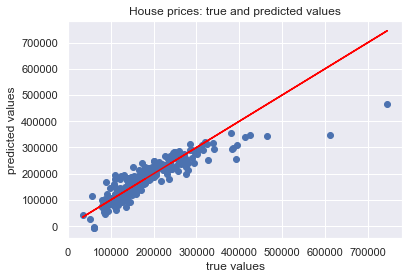

Mean absolute error of the prediction is: 24948.463162288062
Mean squared error of the prediction is: 1474468360.9962268
Root mean squared error of the prediction is: 38398.80676526586
Mean absolute percentage error of the prediction is: 15.033353396584884


In [101]:
#Here we plot the predictions against the target
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("House prices: true and predicted values")
plt.show()


print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

In the above scatter plot, we can see that most of the values are clustered nicely around the prediction line.  The model is less effective on the handful of pricey outliers.  Instead of including external variables (I was advised against this), we engineered an interaction variable using year build and year remodeled, which improved the performance of the OLS model by several points.  Adding external variables to a model can introduce bias as well as data integration issues.  